In [106]:
import os 
from pathlib import Path
import pandas as pd 
import re
import utils
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
#Se leen los datos y se seleccionan las variables que presentan una diferencia
# entre los individuos que presentan estres y los que no
data_path = Path(os.getcwd()).parent / "data"
silver_path = data_path / "silver" / "dreadditCleanTest.csv"
df = pd.read_csv(silver_path)

#### Caracteristicas extraidas a mano

In [108]:
X = df[["singular_pronouns","adj_adv"]]
y = df.label


In [109]:
models_path = Path(os.getcwd()).parent / "models"


# Lista para almacenar los nombres de archivos
pkl_files = []

# Recorre todos los archivos en el directorio especificado
for filename in os.listdir(models_path):
    if filename.endswith('.pkl'):
        pkl_files.append(filename)

In [110]:
scores = {}
for model_name in pkl_files:
    ruta = os.path.join(models_path,model_name)
    # Cargar el modelo
    with open(ruta, 'rb') as file:
        model = pickle.load(file)

    f1s= np.round(utils.evaluate_model(model, X,y).mean(),3)
    scores[model_name.split(".")[0]] = f1s



In [111]:
scores

{'AdaBoost_caracteristicas_manual': 0.648,
 'AdaBoost_TFIDF+manuales': 0.648,
 'AdaBoost_TFIDF': 0.648,
 'Decision Tree_caracteristicas_manual': 0.69,
 'Decision Tree_TFIDF+manuales': 0.69,
 'Decision Tree_TFIDF': 0.69,
 'Gradient Boosting_caracteristicas_manual': 0.641,
 'Gradient Boosting_TFIDF+manuales': 0.641,
 'Gradient Boosting_TFIDF': 0.641,
 'K-Nearest Neighbors_caracteristicas_manual': 0.583,
 'K-Nearest Neighbors_TFIDF+manuales': 0.583,
 'K-Nearest Neighbors_TFIDF': 0.583,
 'Logistic Regression_caracteristicas_manual': 0.67,
 'Logistic Regression_TFIDF+manuales': 0.67,
 'Logistic Regression_TFIDF': 0.67,
 'Naive Bayes_caracteristicas_manual': 0.684,
 'Naive Bayes_TFIDF+manuales': 0.684,
 'Naive Bayes_TFIDF': 0.684,
 'Random Forest_caracteristicas_manual': 0.512,
 'Random Forest_TFIDF+manuales': 0.517,
 'Random Forest_TFIDF': 0.521,
 'SVM_caracteristicas_manual': 0.693,
 'SVM_TFIDF+manuales': 0.693,
 'SVM_TFIDF': 0.693,
 'XGBoost_caracteristicas_manual': 0.683,
 'XGBoost_TFIDF

In [112]:
#Configuracion de visualizaciones 

# Configurar el estilo de fondo con una cuadrícula
sns.set_style("whitegrid")

# Establecer una paleta de colores profesional
sns.set_palette(['#2596be'])

# Configurar la tipografía y el tamaño de la fuente
sns.set_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", "font.sans-serif": ["Helvetica", "Arial"]})

# Desactivar spines innecesarios
sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

In [113]:
scores["RoBERTa"] = 0.811

In [114]:
scores = pd.DataFrame.from_dict(scores, orient="index").reset_index()
scores.columns=["model","fscore"]


In [115]:
scores = scores.sort_values("fscore", ascending=False)

C:\Users\franc\AppData\Local\Temp\ipykernel_12196\1855271777.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="fscore",y="model",data=scores, palette=colors_pal)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

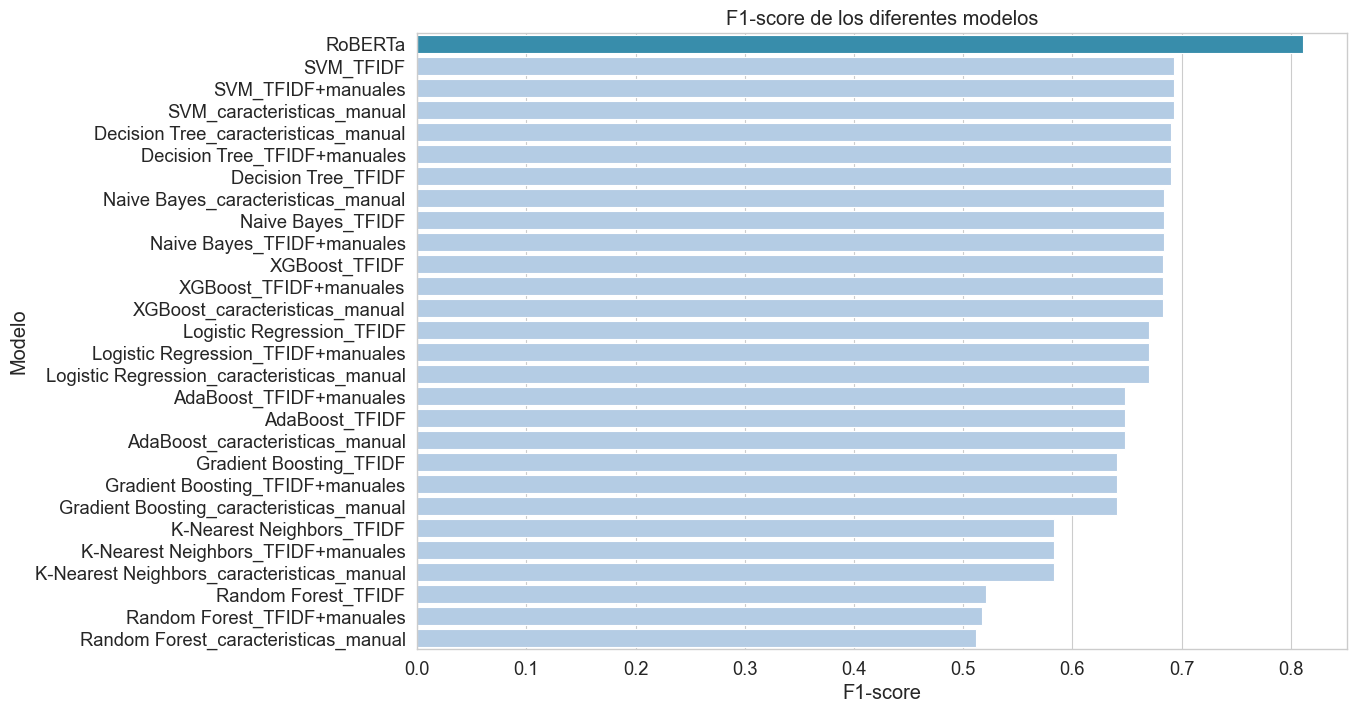

In [121]:

# Palabras que deben tener un color especial
special_words = ['RoBERTa']

# Función para aplicar colores
def assign_colors(words, special_words, color_special, color_default):
    return [color_special if word in special_words else color_default for word in words]

# Colores por defecto y especial
default_color = '#acccec'  # Azul por defecto
special_color = '#2596be'  

# Aplicar la función de asignación de colores
colors_pal = assign_colors(scores['model'], special_words, special_color, default_color)

fig, axes = plt.subplots(figsize=(12, 8))
plt.title("F1-score de los diferentes modelos")
sns.barplot(x="fscore",y="model",data=scores, palette=colors_pal)
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.tight_layout